In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from sklearn.metrics import mean_squared_error


In [26]:
# Create a discrete colormap with 5 colors (one for ground truth, and one for each network architecture)
arch_names = ['g_true', 'FF', 'PI-FF', 'DGM', 'PI-DGM']
batlow_colors = cmc.batlow(np.linspace(0, 1, len(arch_names)))

# Create a custom palette dictionary mapping each class to a color
custom_palette = {arch_name: batlow_colors[i] for i, arch_name in enumerate(arch_names)}

In [32]:
# Plate (2D)

alpha = 55
length = 50 # length of the plate, 50 mm
time = 8 # total time, 4 s
x_nodes = 30 # number of nodes - 1
y_nodes = 20 # made this different so that I could tell which axis is which

dx = length / x_nodes # distance between nodes
dy = length / y_nodes # distance between nodes
# time step, must be less or equal to than min of dx^2 / (4 * alpha) and dy^2 / (4 * alpha)
dt = np.min([0.25 * dx**2 / alpha, 0.25 * dy**2 / alpha]) 

x_train = np.linspace(0, length, x_nodes)
y_train = np.linspace(0, length, y_nodes)
t_all = np.linspace(0, time, int(time / dt))
train_low = len(t_all) // 8 # discard 1st 1/8th of time
train_high = 2 * train_low 
t_train = t_all[train_low:train_high] # train on 2nd 1/8th of time
t_test = t_all[train_high:]

u = np.zeros((x_nodes, y_nodes)) + 20 # middle of the plate is 20 degrees
# for i in range(len(u[0, :])): # top ranges from 20 to 78 degrees linearly
#     u[0, i] = 20 + 3*i
u[0, :] = 100 # bottom side of the plate is 100 degrees
# u[-1, :] = 100 # top side of the plate is 100 degrees
# u[:, 0] = 100 # left side of the plate is 100 degrees
# u[:, -1] = 100 # right side of the plate is 100 degrees

heat_data = np.zeros((int(time / dt), x_nodes, y_nodes))

for counter in range(heat_data.shape[0]):
    w = u.copy()

    for i in range(1, x_nodes - 1):
        for j in range(1, y_nodes - 1):
            dd_ux = (w[i - 1, j] - 2 * w[i, j] + w[i + 1, j]) / dx**2
            dd_uy = (w[i, j - 1] - 2 * w[i, j] + w[i, j + 1]) / dy**2

            u[i, j] = dt * alpha * (dd_ux + dd_uy) + w[i, j]

    heat_data[counter, :, :] = u.copy()

    # print(f't: {counter * dt:.2f} s, Ave temp: {np.mean(u):.2f} C')

print(heat_data.shape)

(633, 30, 20)


In [30]:
def plot_heat_map(
        title,
        samp_time,
        x_1,
        x_2,
        heat
):
    fig = plt.figure()
    plt.title(f'{title}\nt: {samp_time:.2f} s')
    pcm = plt.pcolormesh(x_2, x_1, heat, cmap='cmc.batlow', vmin=0, vmax=100)
    cbar = plt.colorbar(pcm)
    cbar.set_label('Temperature (ºC)')
    plt.xlabel('$x_{2}$ mm')
    plt.ylabel('$x_{1}$ mm')
    plt.show()


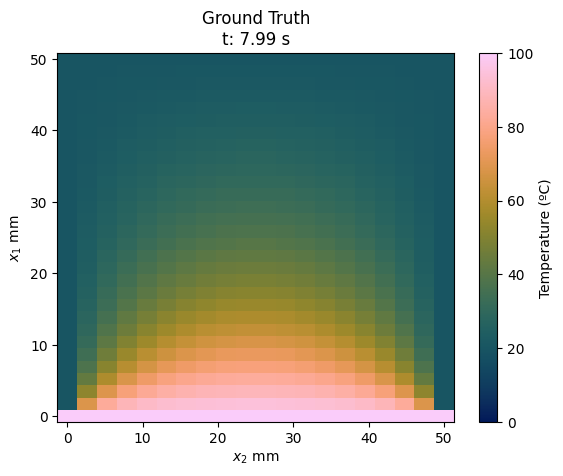

In [ ]:
samp_time = len(t_train) // 2 # plot the time in the middle of training

plot_heat_map('Ground Truth', (len(t_all))*dt, x_train, y_train, heat_data[-1, :, :])


In [5]:
import os
import sys

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from deep_learning import deep_network_core as core, utils
import torch
import torch.nn as nn
from torch.autograd import grad as autograd

In [6]:
# Create meshgrids for train and test  
Tr, Xr, Yr = np.meshgrid(t_train, x_train, y_train)

inpt = np.column_stack((
    Tr.transpose(1, 0, 2).ravel(), # Transpose needed to get in t, x, y order
    Xr.transpose(1, 0, 2).ravel(), 
    Yr.transpose(1, 0, 2).ravel(),
    ))
oupt = heat_data[train_low:train_high, :, :].ravel()

Tr_test, Xr_test, Yr_test = np.meshgrid(t_test, x_train, y_train)

inpt_test = np.column_stack((
    Tr_test.transpose(1, 0, 2).ravel(), # Transpose needed to get in t, x, y order
    Xr_test.transpose(1, 0, 2).ravel(), 
    Yr_test.transpose(1, 0, 2).ravel(),
    ))


In [7]:
class MSE_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.MSELoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

class Huber_Loss(core.LOSS):
    def __init__(self):
        self.loss = nn.HuberLoss()
        
    def __call__(self, target, result, model):
        return self.loss(target, result)

class PHYSICS_Loss(core.LOSS):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, target, result, model):
        x = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
        y = torch.empty((100, 1)).uniform_(0, length).requires_grad_(True)
        t = torch.empty((100, 1)).uniform_(train_low*dt, time).requires_grad_(True)
        inp = torch.cat((t, x, y), axis=1)
        # xs = torch.stack((x, y))
        zs = model(inp)
        pde = utils.dy_dt(zs, t) - self.alpha * utils.laplacian_2d(zs, x, y) # dz/dt - (ddz/dxx + ddz/dyy)
        # pde = utils.dy_dt(zs, t) - utils.laplacian(zs, xs) # dz/dt - (ddz/dxx + ddz/dyy)
        return torch.mean(pde**2)

In [8]:
network_nn = core.PINN(3, 1, 64, 3, [(1, MSE_Loss())])

print("Training NN")
network_nn.fit(inpt, oupt, lr=1e-5, epochs=70000)


Training NN
Epoch 1/70000 loss: 1.6e+03
Epoch 7000/70000 loss: 3.8e+02
Epoch 14000/70000 loss: 26
Epoch 21000/70000 loss: 4.2
Epoch 28000/70000 loss: 0.99
Epoch 35000/70000 loss: 0.23
Epoch 42000/70000 loss: 0.087
Epoch 49000/70000 loss: 0.057
Epoch 56000/70000 loss: 0.045
Epoch 63000/70000 loss: 0.038
Epoch 70000/70000 loss: 0.033


[1587.6590576171875,
 1587.4271240234375,
 1587.1953125,
 1586.9637451171875,
 1586.7318115234375,
 1586.500244140625,
 1586.2689208984375,
 1586.0374755859375,
 1585.8062744140625,
 1585.5750732421875,
 1585.34375,
 1585.1129150390625,
 1584.8822021484375,
 1584.651123046875,
 1584.4205322265625,
 1584.1900634765625,
 1583.95947265625,
 1583.729248046875,
 1583.4989013671875,
 1583.2685546875,
 1583.038330078125,
 1582.8084716796875,
 1582.57861328125,
 1582.3486328125,
 1582.1187744140625,
 1581.888916015625,
 1581.659423828125,
 1581.4300537109375,
 1581.2003173828125,
 1580.970947265625,
 1580.7415771484375,
 1580.512451171875,
 1580.2830810546875,
 1580.053955078125,
 1579.8248291015625,
 1579.5955810546875,
 1579.36669921875,
 1579.1375732421875,
 1578.9090576171875,
 1578.6805419921875,
 1578.452880859375,
 1578.2254638671875,
 1577.9986572265625,
 1577.77197265625,
 1577.545654296875,
 1577.31982421875,
 1577.0938720703125,
 1576.8681640625,
 1576.6427001953125,
 1576.417602539

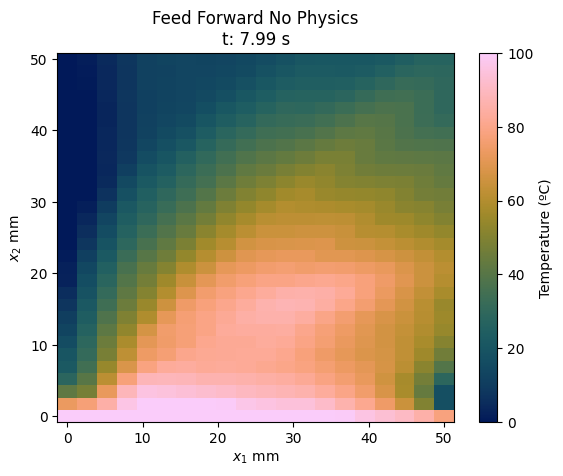

In [ ]:
# Generate train and test data from the model for analysis and plotting
pred_nn_train = network_nn.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))
pred_nn_test = network_nn.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

plot_heat_map('Feed Forward No Physics', (len(t_all))*dt, x_train, y_train, pred_nn_test[-1, :, :])


In [10]:
mses_nn_train = []
for i, pred in enumerate(pred_nn_train):
    mses_nn_train.append(mean_squared_error(heat_data[train_low+i, :, :], pred))

mses_nn_test = []
for i, pred in enumerate(pred_nn_test):
    mses_nn_test.append(mean_squared_error(heat_data[train_high+i, :, :], pred))

# plt.figure()
# plt.semilogy(t_train, mses_nn_train, '-', c=batlow_colors[0])
# plt.semilogy(t_test, mses_nn_test, '--', c=batlow_colors[0])
# plt.grid(True)
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Time (s)')
# plt.title('')
# plt.show()

In [11]:
network_pinn = core.PINN(3, 1, 64, 3, [(1, MSE_Loss()), (1, PHYSICS_Loss(alpha))])

print("Training PINN")
network_pinn.fit(inpt, oupt, lr=1e-5, epochs=70000)

Training PINN
Epoch 1/70000 loss: 1.6e+03
Epoch 7000/70000 loss: 3.2e+02
Epoch 14000/70000 loss: 18
Epoch 21000/70000 loss: 7.4
Epoch 28000/70000 loss: 3.4
Epoch 35000/70000 loss: 2.3
Epoch 42000/70000 loss: 2.1
Epoch 49000/70000 loss: 1.8
Epoch 56000/70000 loss: 1.7
Epoch 63000/70000 loss: 1.7
Epoch 70000/70000 loss: 1.6


[1593.24365234375,
 1593.0576171875,
 1592.8712158203125,
 1592.6849365234375,
 1592.498291015625,
 1592.3114013671875,
 1592.1241455078125,
 1591.9368896484375,
 1591.7496337890625,
 1591.5626220703125,
 1591.3753662109375,
 1591.187744140625,
 1591.0,
 1590.8121337890625,
 1590.6239013671875,
 1590.4359130859375,
 1590.24755859375,
 1590.0592041015625,
 1589.8704833984375,
 1589.6817626953125,
 1589.4927978515625,
 1589.303466796875,
 1589.1138916015625,
 1588.92431640625,
 1588.734130859375,
 1588.5439453125,
 1588.353759765625,
 1588.163330078125,
 1587.9725341796875,
 1587.78173828125,
 1587.59033203125,
 1587.3988037109375,
 1587.2066650390625,
 1587.0145263671875,
 1586.82177734375,
 1586.628662109375,
 1586.4354248046875,
 1586.241455078125,
 1586.047607421875,
 1585.853271484375,
 1585.6585693359375,
 1585.46337890625,
 1585.267822265625,
 1585.0718994140625,
 1584.875,
 1584.67822265625,
 1584.4808349609375,
 1584.282958984375,
 1584.08447265625,
 1583.885498046875,
 1583.685

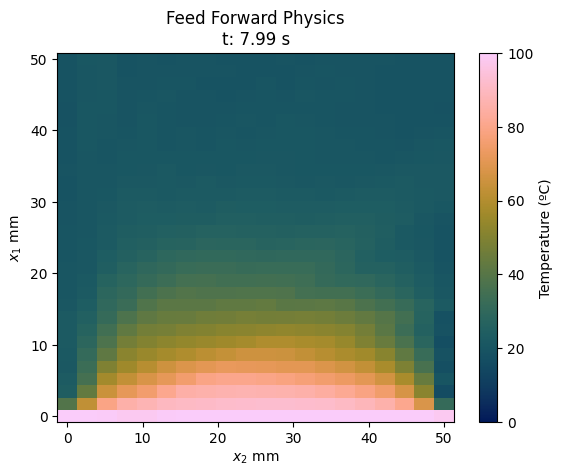

In [34]:
pred_pinn_train = network_pinn.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))
pred_pinn_test = network_pinn.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

plot_heat_map('Feed Forward Physics', (len(t_all))*dt, x_train, y_train, pred_pinn_test[-1, :, :])

# fig = plt.figure(figsize=(12.8, 4.8))
# fig.suptitle('Feed Forward Physics')
# plt.subplot(1, 2, 1)
# pcm = plt.pcolormesh(y_train, x_train, pred_pinn_train[samp_time, :, :], cmap='cmc.batlow', vmin=0, vmax=100)
# cbar = plt.colorbar(pcm)
# cbar.set_label('Temperature (°C)')
# plt.title(f'Trained\n t: {(samp_time+train_low)*dt:.2f} s')
# plt.xlabel('$x_{1}$ (mm)')
# plt.ylabel('$x_{2}$ (mm)')
# plt.subplot(1, 2, 2)
# pcm = plt.pcolormesh(y_train, x_train, pred_pinn_test[samp_time, :, :], cmap='cmc.batlow', vmin=0, vmax=100)
# cbar = plt.colorbar(pcm)
# cbar.set_label('Temperature (°C)')
# plt.title(f'Extrapolated\n t: {(samp_time+train_high)*dt:.2f} s')
# plt.xlabel('$x_{1}$ (mm)')
# plt.ylabel('$x_{2}$ (mm)')
# plt.tight_layout()
# plt.show()


In [13]:
mses_pinn_train = []
for i, pred in enumerate(pred_pinn_train):
    mses_pinn_train.append(mean_squared_error(heat_data[i+train_low, :, :], pred))

mses_pinn_test = []
for i, pred in enumerate(pred_pinn_test):
    mses_pinn_test.append(mean_squared_error(heat_data[train_high+i, :, :], pred))

# plt.figure()
# plt.semilogy(t_train, mses_pinn_train, 'b-')
# plt.semilogy(t_test, mses_pinn_test, 'b--')
# plt.grid(True)
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Time (s)')
# plt.title('I need a title')
# plt.show()

In [14]:
network_dgm = core.DGM(3, 1, 128, 4, [(1, MSE_Loss())])
print("Training DGM")
network_dgm.fit(inpt, oupt, lr=2e-3, epochs=6000)

Training DGM
Epoch 1/6000 loss: 1.9e+03
Epoch 600/6000 loss: 68
Epoch 1200/6000 loss: 32
Epoch 1800/6000 loss: 20
Epoch 2400/6000 loss: 15
Epoch 3000/6000 loss: 12
Epoch 3600/6000 loss: 10
Epoch 4200/6000 loss: 8.6
Epoch 4800/6000 loss: 7.8
Epoch 5400/6000 loss: 7.1
Epoch 6000/6000 loss: 6.6


[1912.3988037109375,
 1808.18603515625,
 1709.4617919921875,
 1616.239990234375,
 1528.505615234375,
 1446.2264404296875,
 1369.35498046875,
 1297.837158203125,
 1231.6243896484375,
 1170.642578125,
 1114.81591796875,
 1064.0621337890625,
 1018.2787475585938,
 977.3446655273438,
 941.1146240234375,
 909.411376953125,
 882.0217895507812,
 858.6928100585938,
 839.1390991210938,
 823.0266723632812,
 809.9829711914062,
 799.6004028320312,
 791.441162109375,
 785.056396484375,
 780.00537109375,
 775.8739013671875,
 772.286865234375,
 768.9191284179688,
 765.5119018554688,
 761.8690185546875,
 757.8484497070312,
 753.3677368164062,
 748.389892578125,
 742.9239501953125,
 737.0518188476562,
 730.9271850585938,
 724.6505737304688,
 718.1747436523438,
 711.60498046875,
 705.0400390625,
 698.5657958984375,
 692.2604370117188,
 686.1854248046875,
 680.3816528320312,
 674.865966796875,
 669.6482543945312,
 664.7265014648438,
 660.084716796875,
 655.6998901367188,
 651.55712890625,
 647.63171386718

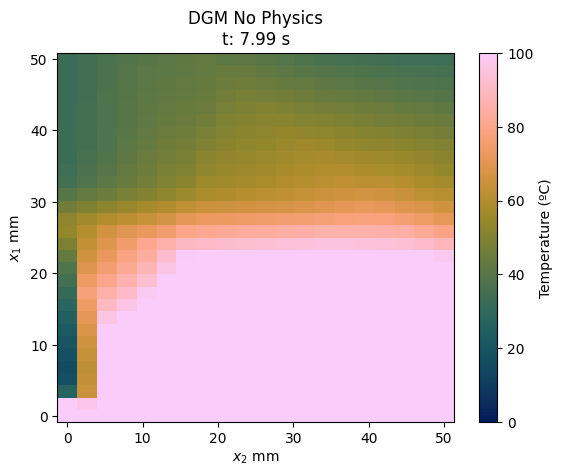

In [35]:
pred_dgm_train = network_dgm.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))
pred_dgm_test = network_dgm.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

plot_heat_map('DGM No Physics', (len(t_all))*dt, x_train, y_train, pred_dgm_test[-1, :, :])


In [16]:

mses_dgm_train = []
for i, pred in enumerate(pred_dgm_train):
    mses_dgm_train.append(mean_squared_error(heat_data[train_low+i, :, :], pred))

mses_dgm_test = []
for i, pred in enumerate(pred_dgm_test):
    mses_dgm_test.append(mean_squared_error(heat_data[train_high+i, :, :], pred))

# plt.figure()
# plt.semilogy(t_train, mses_dgm_train, 'b-')
# plt.semilogy(t_test, mses_dgm_test, 'b--')
# plt.grid(True)
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Time (s)')
# plt.title('I need a title')
# plt.show()

In [17]:
network_pi_dgm = core.DGM(3, 1, 128, 4, [(1, MSE_Loss()), (1, PHYSICS_Loss(alpha))])
print("Training PI-DGM")
network_pi_dgm.fit(inpt, oupt, lr=2e-3, epochs=6000)

Training PI-DGM
Epoch 1/6000 loss: 2.1e+03
Epoch 600/6000 loss: 1.5e+02
Epoch 1200/6000 loss: 54


KeyboardInterrupt: 

In [ ]:
pred_pi_dgm_train = network_pi_dgm.predict(inpt).reshape((len(t_train), len(x_train), len(y_train)))
pred_pi_dgm_test = network_pi_dgm.predict(inpt_test).reshape((len(t_test), len(x_train), len(y_train)))

plot_heat_map('DGM Physics', (len(t_all))*dt, x_train, y_train, pred_pi_dgm_test[-1, :, :])

# fig = plt.figure(figsize=(12.8, 4.8))
# fig.suptitle('DGM Physics')
# plt.subplot(1, 2, 1)
# pcm = plt.pcolormesh(y_train, x_train, pred_pi_dgm_train[samp_time, :, :], cmap='cmc.batlow', vmin=0, vmax=100)
# cbar = plt.colorbar(pcm)
# cbar.set_label('Temperature (°C)')
# plt.title(f'Trained\n t: {(samp_time+train_low)*dt:.2f} s')
# plt.xlabel('$x_{1}$ (mm)')
# plt.ylabel('$x_{2}$ (mm)')
# plt.subplot(1, 2, 2)
# pcm = plt.pcolormesh(y_train, x_train, pred_pi_dgm_test[samp_time, :, :], cmap='cmc.batlow', vmin=0, vmax=100)
# cbar = plt.colorbar(pcm)
# cbar.set_label('Temperature (°C)')
# plt.title(f'Extrapolated\n t: {(samp_time+train_high)*dt:.2f} s')
# plt.xlabel('$x_{1}$ (mm)')
# plt.ylabel('$x_{2}$ (mm)')
# plt.tight_layout()
# plt.show()



In [ ]:
mses_pi_dgm_train = []
for i, pred in enumerate(pred_pi_dgm_train):
    mses_pi_dgm_train.append(mean_squared_error(heat_data[train_low+i, :, :], pred))

mses_pi_dgm_test = []
for i, pred in enumerate(pred_pi_dgm_test):
    mses_pi_dgm_test.append(mean_squared_error(heat_data[train_high+i, :, :], pred))

# plt.figure()
# plt.semilogy(t_train, mses_pi_dgm_train, 'b-')
# plt.semilogy(t_test, mses_pi_dgm_test, 'b--')
# plt.grid(True)
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Time (s)')
# plt.title('I need a title')
# plt.show()

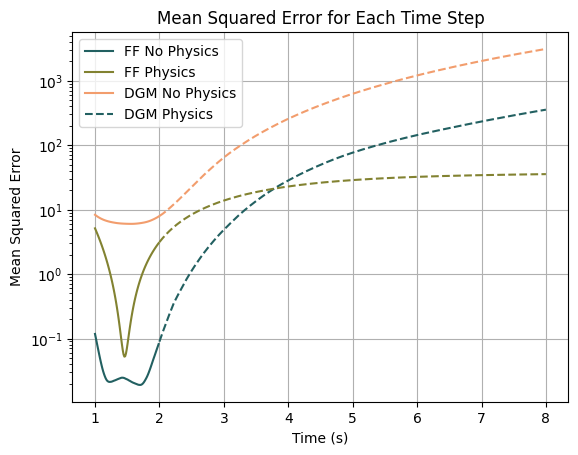

In [18]:
plt.figure()
plt.semilogy(t_train, mses_nn_train, '-', c=batlow_colors[1])
plt.semilogy(t_train, mses_pinn_train, '-', c=batlow_colors[2])
plt.semilogy(t_train, mses_dgm_train, '-', c=batlow_colors[3])
# plt.semilogy(t_train, mses_pi_dgm_train, '-', c=batlow_colors[4])
plt.semilogy(t_test, mses_nn_test, '--', c=batlow_colors[1])
plt.semilogy(t_test, mses_pinn_test, '--', c=batlow_colors[2])
plt.semilogy(t_test, mses_dgm_test, '--', c=batlow_colors[3])
# plt.semilogy(t_test, mses_pi_dgm_test, '--', c=batlow_colors[4])
plt.grid(True)
plt.ylabel('Mean Squared Error')
plt.xlabel('Time (s)')
plt.title('Mean Squared Error for Each Time Step')
plt.legend(['FF No Physics', 'FF Physics', 'DGM No Physics', 'DGM Physics'])
plt.show()

In [ ]:
np.savez(
    'pred_values_alpha55.npz', 
    nn_train_data=pred_nn_train,
    nn_test_data=pred_nn_test,
    pinn_train_data=pred_pinn_train,
    pinn_test_data=pred_pinn_test,
    dgm_train_data=pred_dgm_train,
    dgm_test_data=pred_dgm_test,
    pi_dgm_train_data=pred_pi_dgm_train,
    pi_dgm_test_data=pred_pi_dgm_test,
    )